In [61]:
# all of the imports
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import nltk
import itertools
from nltk.probability import FreqDist

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
num_questions = 500

questions = pd.read_csv("questions.csv", index_col=0, encoding='latin1')[:num_questions]
tags = pd.read_csv("tags.csv", encoding='latin1')[:num_questions]

In [3]:
questions.head()

,OwnerUserId,CreationDate,Score,Title,Body
Id,,,,,
469,147.0,2008-08-02T15:11:16Z,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...
502,147.0,2008-08-02T17:01:58Z,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...
535,154.0,2008-08-02T18:43:54Z,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...
594,116.0,2008-08-03T01:15:08Z,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...
683,199.0,2008-08-03T13:19:16Z,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...


In [4]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 469 to 133860
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OwnerUserId   474 non-null    float64
 1   CreationDate  500 non-null    object 
 2   Score         500 non-null    int64  
 3   Title         500 non-null    object 
 4   Body          500 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 23.4+ KB


In [5]:
tags.head()

,Id,Tag
0,469,python
1,469,osx
2,469,fonts
3,469,photoshop
4,502,python


In [6]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      500 non-null    int64 
 1   Tag     500 non-null    object
dtypes: int64(1), object(1)
memory usage: 7.9+ KB


In [7]:
#group tags by the id of the post since a post can have multiple tags
tags['Tag'] = tags['Tag'].astype(str)

grouped_tags = tags.groupby("Id")['Tag'].apply(lambda tags: ' '.join(tags))
grouped_tags.head(5)

Id
469                           python osx fonts photoshop
502                             python windows image pdf
535    python continuous-integration extreme-programming
594                 python sql database oracle cx-oracle
683                              python arrays iteration
Name: Tag, dtype: object

In [8]:
grouped_tags.reset_index()
grouped_tags_final = pd.DataFrame({'Id':grouped_tags.index, 'Tags':grouped_tags.values})

grouped_tags_final.head(5)

,Id,Tags
0,469,python osx fonts photoshop
1,502,python windows image pdf
2,535,python continuous-integration extreme-programming
3,594,python sql database oracle cx-oracle
4,683,python arrays iteration


In [9]:
questions.drop(columns=['OwnerUserId', 'CreationDate'], axis=1, inplace=True)
questions = questions.merge(grouped_tags_final, on='Id')

questions.head()

,Id,Score,Title,Body,Tags
0,469,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...,python osx fonts photoshop
1,502,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...,python windows image pdf
2,535,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...,python continuous-integration extreme-programming
3,594,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...,python sql database oracle cx-oracle
4,683,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...,python arrays iteration


In [10]:
#Only take quesions with a score greater than 5
#The posts will probably be with a better quality and will be better tagged since they have lots of upvotes

best_questions = questions[questions['Score']>5]

In [11]:
best_questions.drop(columns=['Id', 'Score'], inplace=True)

D:\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [12]:
best_questions.head()

,Title,Body,Tags
0,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...,python osx fonts photoshop
1,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...,python windows image pdf
2,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...,python continuous-integration extreme-programming
3,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...,python sql database oracle cx-oracle
4,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...,python arrays iteration


In [13]:
#Cleaning the tags' column
#Only keep the 100 most popular tags, making it easier to predict the right tag

best_questions['Tags'] = best_questions['Tags'].apply(lambda x: x.split())

all_tags = [item for sublist in best_questions['Tags'].values for item in sublist]
len(all_tags)

<ipython-input-13-fd341b2e5a6f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_questions['Tags'] = best_questions['Tags'].apply(lambda x: x.split())


420

In [14]:
my_set = set(all_tags)
unique_tags = list(my_set)
len(unique_tags)

209

In [15]:
flat_list = [item for sublist in best_questions['Tags'].values for item in sublist]

keywords = nltk.FreqDist(flat_list)

keywords = nltk.FreqDist(keywords)

frequencies_words = keywords.most_common(100)
tags_features = [word[0] for word in frequencies_words]

In [16]:
tags_features

['python',
 'django',
 'windows',
 'xml',
 'linux',
 'osx',
 'database',
 'iteration',
 'oop',
 'mysql',
 'syntax',
 'list',
 'tuples',
 'unicode',
 'pylons',
 'string',
 'regex',
 'ruby',
 'multithreading',
 'cross-platform',
 'sql',
 'monkeypatching',
 'binary',
 'php',
 'user-interface',
 'deployment',
 'c',
 'metadata',
 'unit-testing',
 'swig',
 'escaping',
 'validation',
 'zip',
 'command-line',
 'packaging',
 'enums',
 'gtk',
 'pygtk',
 'distutils',
 'performance',
 'html',
 'mapping',
 'google-app-engine',
 'authentication',
 'fonts',
 'photoshop',
 'image',
 'pdf',
 'continuous-integration',
 'extreme-programming',
 'oracle',
 'cx-oracle',
 'arrays',
 'views',
 'postgresql',
 'bpgsql',
 'methods',
 'integer',
 'literals',
 'protocol-buffers',
 'ftp',
 'webserver',
 'tkinter',
 'release-management',
 'serial-port',
 'apache',
 'apache2',
 'matlab',
 'markup',
 'floating-point',
 'urllib',
 'data-structures',
 'dom',
 'xpath',
 'nodes',
 'mp3',
 'c++',
 'code-generation',
 'lxml

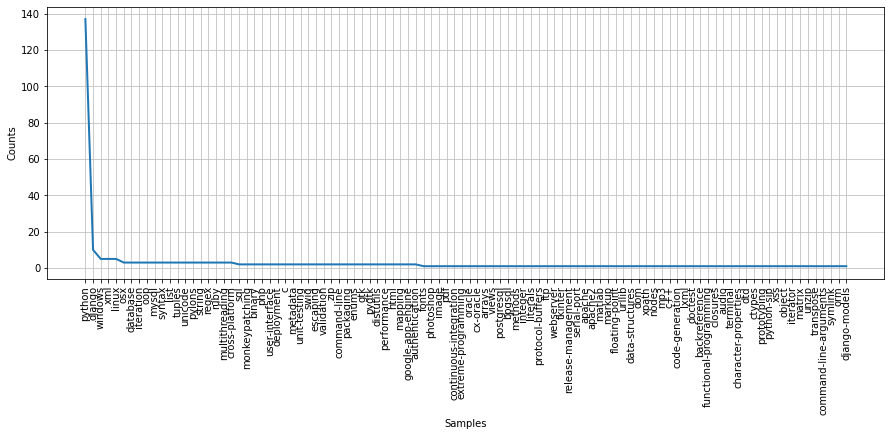

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [50]:
fig, ax = plt.subplots(figsize=(15, 5))
keywords.plot(100, cumulative=False)

In [20]:
# Separating X and y from original dataframe

X = best_questions.iloc[:,0:2]
y = best_questions.iloc[:,2]

X.head()

,Title,Body
0,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...
1,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...
2,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...
3,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...
4,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...


In [21]:
y.head()

0                      [python, osx, fonts, photoshop]
1                        [python, windows, image, pdf]
2    [python, continuous-integration, extreme-progr...
3           [python, sql, database, oracle, cx-oracle]
4                          [python, arrays, iteration]
Name: Tags, dtype: object

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [42]:
X_train.shape, X_test.shape

((109, 2), (28, 2))

In [43]:
y_train.shape, y_test.shape

((109,), (28,))